### **Comparing cosine and von mises tuning models**

In [44]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys
import os

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from session_utils import getTrainTest, loadDataset, get_Sessions
from CosineTuning import *
from lineplots import plotsd
from sklearn.model_selection import KFold
from plotting_utils import figSize


data_dir    = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/'
fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'
participant = 'T5/historical/'
min_nblocks = 3

# preprocess by selecting sessions with a minimal block count:
files  = loadDataset(data_dir, participant)
files  = get_Sessions(files, min_nblocks = 3)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
cos.theta

2.912955534972678

In [87]:
from recalibration_utils import get_BlockwiseMeanSubtracted
from session_utils import getFields


figSize(7, 15)
np.random.seed(41)


# general settings: 
fields = ['TX', 'cursorPos', 'targetPos']
task   = None
blocks = None

# Tuning curve plotting:
n_bins     = 15
cv         = 5


cos_data = dict()
cos_data['tuning']     = np.zeros((2, 192, 3))  # r_0 (baseline), alpha (modulation), theta (preferred dir)
cos_data['curves_old'] = list()
cos_data['curves_new'] = list()
cos_data['binned_rates_old'] = list()
cos_data['binned_rates_new'] = list()

for i, f in enumerate([files[i] for i in range(2)]):
    dat     = DataStruct(f, causal_filter = 2)
    results = getFields(dat, fields, task = task, blocks = blocks)

    for key, value in results.items():
        results[key] = [np.concatenate(x) for x in value]

    #neural, _  = get_BlockwiseMeanSubtracted(results['TX'], results['TX'], concatenate = True)
    neural     = np.concatenate(results['TX'])
    vel_signal = np.concatenate([x - y for x, y in zip(results['targetPos'], results['cursorPos'])])

    vel_angle = getAngles(vel_signal, returnFullAngle = True)
    split     = int(vel_angle.shape[0] / 2)

    for j, unit in enumerate(range(192)):
        unit_data            = neural[:, unit]
        FR_estimates, labels = fitTuningCurve(neural = unit_data, traj = vel_signal, n_AngleBins = n_bins, cv = cv)
        cos                  = CosineTuningModel().fit(vel_angle, unit_data)
        preds_cos            = cos.predict(labels)
        cos_data['tuning'][i, j, 0] = cos.r_0
        cos_data['tuning'][i, j, 1] = cos.alpha
        cos_data['tuning'][i, j, 2] = cos.theta
    
        key = 'old' if i == 1 else 'new'
        
        cos_data['curves_' + key].append(preds_cos)
        cos_data['binned_rates_' + key].append(FR_estimates)
         

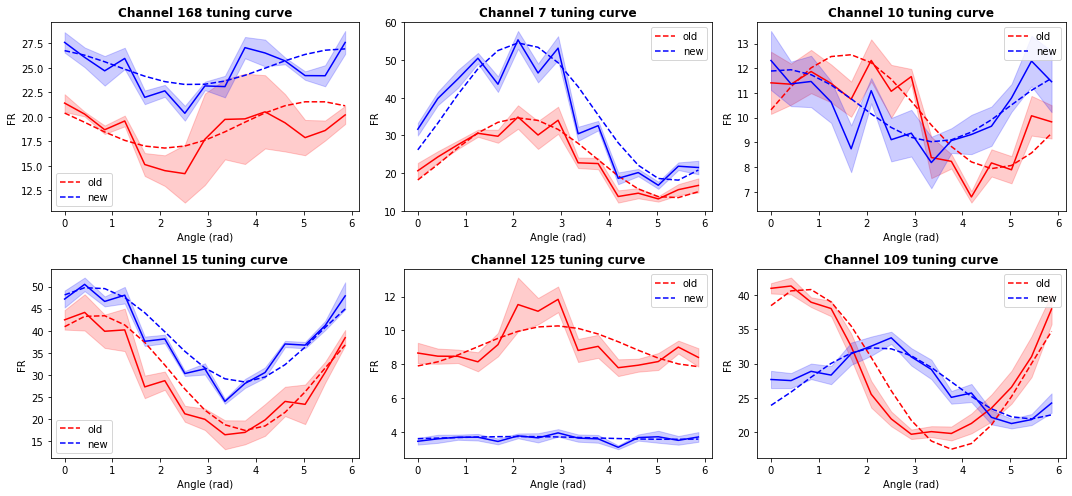

In [102]:
np.random.seed(10)


for i, ch in enumerate([168, 7, 10, 15, 125, 109]):
    plt.subplot(2, 3, i + 1)

    for key, color in zip(['old', 'new'], ['r', 'b']):

        ch_preds  = cos_data['curves_' + key][ch].T
        ch_actual = cos_data['binned_rates_' + key][ch].T

        plotsd(data = ch_actual, color = color, time_bins = labels, toggleSE = True)
        plt.plot(labels, ch_preds, c = color, linestyle = '--', label = key)
    
    plt.title('Channel ' + str(ch) + ' tuning curve', fontweight = 'bold')
    plt.xlabel('Angle (rad)')
    plt.ylabel('FR')
    plt.legend()
    
plt.tight_layout()
plt.savefig(fig_path + 'T5_cosine_drift', format = 'pdf')
plt.show()

In [124]:
files[10]

'/oak/stanford/groups/shenoy/gwilson/nonstationarities/T5/historical/t5.2016.10.31.mat'

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Holdout performance (ref): R^2 =  -0.04982310589024204
Holdout performance (new): R^2 =  0.5185217384710336
Ref decoder pearson r:  0.09330091895265649


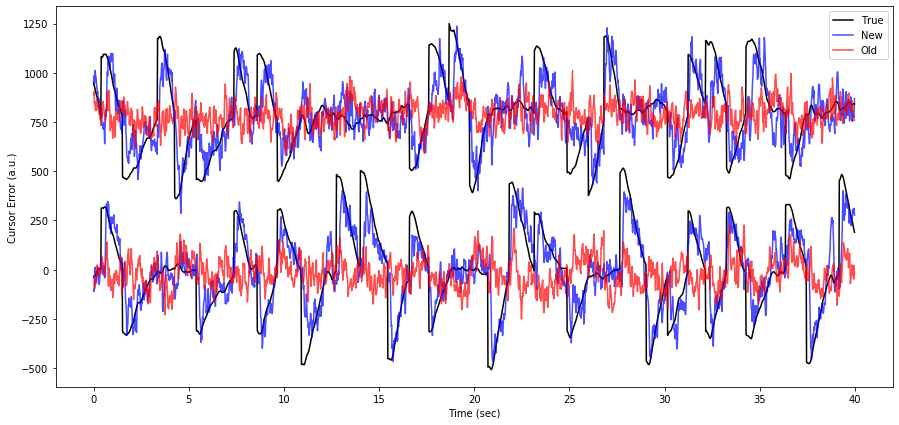

In [125]:
from sklearn.linear_model import LinearRegression

fields = ['TX', 'cursorPos', 'targetPos']

dat     = DataStruct(files[0], causal_filter = 2)

ref_data = getTrainTest(dat, fields, train_size = 0.67, task = task, blocks = blocks, shuffle = False, returnFlattened = True)

train_x = ref_data['train_TX']
test_x  = ref_data['test_TX']
train_x, test_x  = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)

train_y = np.concatenate(ref_data['train_targetPos']) - np.concatenate(ref_data['train_cursorPos'])
test_y  = np.concatenate(ref_data['test_targetPos']) - np.concatenate(ref_data['test_cursorPos'])

ref_decoder = LinearRegression().fit(train_x, train_y)


dat      = DataStruct(files[10], causal_filter = 2)
new_data = getTrainTest(dat, fields, train_size = 0.67, task = task, blocks = blocks, shuffle = False, returnFlattened = True)

train_x = new_data['train_TX']
test_x  = new_data['test_TX']
train_x, test_x  = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)

train_y = np.concatenate(new_data['train_targetPos']) - np.concatenate(new_data['train_cursorPos'])
test_y  = np.concatenate(new_data['test_targetPos']) - np.concatenate(new_data['test_cursorPos'])

new_decoder = LinearRegression().fit(train_x, train_y)
    
    
ref_scores  = ref_decoder.score(test_x, test_y)
print('Holdout performance (ref): R^2 = ', np.mean(ref_scores))
new_scores  = new_decoder.score(test_x, test_y)
print('Holdout performance (new): R^2 = ', np.mean(new_scores))
pearson_r = np.corrcoef(ref_decoder.predict(test_x).flatten(), test_y.flatten())
print('Ref decoder pearson r: ', pearson_r[0, 1])

times  = np.arange(6000, 8000) 
colors = ['red', 'blue'] 

for i in range(2):
    plt.plot((times - times[0]) / 50, test_y[times, i] + (i * 800), color = 'k')
    plt.plot((times - times[0]) / 50, new_decoder.predict(test_x[times, :])[:, i] + (i * 800), linestyle = '-', color = 'blue', alpha = 0.7)
    plt.plot((times - times[0]) / 50, ref_decoder.predict(test_x[times, :])[:, i] + (i * 800), linestyle = '-', color = 'red', alpha = 0.7)
plt.legend(['True', 'New', 'Old'])
plt.xlabel('Time (sec)')
plt.ylabel('Cursor Error (a.u.)')


plt.savefig(fig_path + 'SNR/example_tuning_shift_decoded_session', format = 'pdf')
plt.show()


In [108]:
len(ref_data['train_targetPos'])

4